<div style="text-align: center;">
<h1>Giełda pracy IT</h1>
<h3>Projekt końcowy - Metody Uczenia maszynowego 2019/2020</h3>
<ul>
    <li>Mateusz Gałasiński | 234054</li>
    <li>Jakub Kurek | 234078</li>
    <li>Patrycja Szczakowska | 234121</li>
    <li>Maciej Majchrowski | 234088</li>
    <li>Bartosz Janicki | 234065</li>
</ul>
</div>

In [1]:
!pip install scipy numpy matplotlib pandas sklearn tabulate seaborn folium geopy geopandas requests> /dev/null
from sklearn import metrics
%matplotlib notebook

You should consider upgrading via the '/Users/majchr/Developing/studia-python/MUM/MUM/ENV/bin/python -m pip install --upgrade pip' command.


In [2]:
# import importlib
# import sys
# importlib.reload(sys.modules['statistics.company'])
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split, learning_curve, permutation_test_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, plot_roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tabulate import tabulate
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import os
import sys
sys.path.insert(0, os.path.abspath('./module-dir'))

In [3]:
from dataset_provider.provider import get_dataset
from dataset_provider.config import create_global_config
cfg = create_global_config()
df = get_dataset(cfg)

/Users/majchr/Developing/studia-python/MUM/MUM/jupyter/module-dir/dataset_provider/provider.py:28: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(mapped_val) is 0 or len(mapped_val[0]) is 0:
/Users/majchr/Developing/studia-python/MUM/MUM/jupyter/module-dir/dataset_provider/provider.py:28: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(mapped_val) is 0 or len(mapped_val[0]) is 0:


Taking data from local file...
Found 304 job ads without salary range or currency
(1249, 75)
        salary_from     salary_to
count   1249.000000   1249.000000
mean   11148.760608  15884.851081
std     4540.909690   5114.312359
min     1250.000000   1750.000000
25%     8000.000000  12100.000000
50%    10000.000000  16000.000000
75%    14000.000000  19000.000000
max    44000.000000  50000.000000
Found 8 countries and 4 currencies!
Dropping foreign countries and translating currencies...
Unique countries: 1, currencies: 1, observations: 1230


/Users/majchr/Developing/studia-python/MUM/MUM/ENV/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# Statistics

### Plot company sizes and salary ranges

In [ ]:
from statistics.company import plot_stats
plot_stats(df)

In [ ]:
from statistics.percentage import count_percentage
count_percentage(df)

---------------------------------------------------------------------------

# Heat maps

In [ ]:
from heat_maps.density_map import density_heat_map
density_heat_map(df)

<h2>Get province data </h2>

In [ ]:
from heat_maps.salary_map import show_map
show_map(df)

---------------------------------------------------------------------------

# Dimensionality reduction experiments

In [4]:
pca_df = df.copy()
for col in ["city", "Unnamed: 0", "title", "company_size", "country_code", "marker_icon", "company_name",
            "latitude", "longitude", "salary_currency", "published_at", "remote_interview", "id",
            "Vert.x", "skills", "-"]:
                pca_df=pca_df.drop(col, axis=1)
col_level = ['.NET', 'Design', 'Network', 'REST API', 'Embeded',
       'Cloud', 'Database', 'Android', 'IT', 'Soft Skills', 'Scrum master',
       'Mobile', 'Common', 'JavaScript', 'DevOps', 'Software engineering',
       'Testing', 'Automation', 'Shell Scripting', 'Backend', 'Data Science',
       'Blockchain', 'C++', 'Client Service', 'Front-end', 'Civil Engineering',
       'Developer', 'iOS', 'SQL', 'Python', 'PHP', 'Erlang', 'Scala', 'Git',
       'Games', 'Golang', 'Google', 'Java', 'Web', 'Consultant',
       'Project Manager', 'Analitics', 'CRM', 'Perl', 'R', 'Ruby', 'Rust',
       'SAP', 'CSS', 'XML', 'Salesforce', 'API', 'Data', 'Excel']
col_other = ['remote', 'salary_from', 'salary_to', 'employment_type_b2b', 'employment_type_mandate_contract', 'employment_type_permanent']
print(pca_df.columns)
cols_for_encoding = [c for c in pca_df.select_dtypes(include=['object']).copy().columns if c != "experience_level"]
print(cols_for_encoding)
pca_df = pd.get_dummies(pca_df, columns=cols_for_encoding)
n_components_pca = cfg.n_components_pca

Index(['remote', 'experience_level', 'salary_from', 'salary_to',
       'employment_type', '.NET', 'Design', 'Network', 'REST API', 'Embeded',
       'Cloud', 'Database', 'Android', 'IT', 'Soft Skills', 'Scrum master',
       'Mobile', 'Common', 'JavaScript', 'DevOps', 'Software engineering',
       'Testing', 'Automation', 'Shell Scripting', 'Backend', 'Data Science',
       'Blockchain', 'C++', 'Client Service', 'Front-end', 'Civil Engineering',
       'Developer', 'iOS', 'SQL', 'Python', 'PHP', 'Erlang', 'Scala', 'Git',
       'Games', 'Golang', 'Google', 'Java', 'Web', 'Consultant',
       'Project Manager', 'Analitics', 'CRM', 'Perl', 'R', 'Ruby', 'Rust',
       'SAP', 'CSS', 'XML', 'Salesforce', 'API', 'Data', 'Excel'],
      dtype='object')
['employment_type']


In [8]:
def get_vatiance_rations(featureset_standatized):
    covariance_matrix = np.cov(featureset_standatized.T)
    eigen_vals, eigen_vecs = np.linalg.eig(covariance_matrix)
    return eigen_vals, eigen_vecs

def plot_variance_explained_ratios(eigen_vals, eigen_vecs, features, extend_title = ""):
    #calculate cumulative sum of explained variances
    tot = sum(eigen_vals)
    var_exp = [(i/tot) for i in sorted (eigen_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    plt.figure(figsize=(15,15))
    plt.bar(range(1, features.shape[0] + 1), var_exp, alpha=0.5, align='center', label='individual explained variance')
    plt.step(range(1,features.shape[0] + 1), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio' + extend_title)
    plt.xlabel('Principal component index')
    plt.xticks(range(features.shape[0]),features, rotation=90, ha='left')
    plt.legend(loc='best')
    plt.show()

def get_pca_data(x, n_c = cfg.n_components_pca):
    sc = StandardScaler()
    x_standarded = sc.fit_transform(x)
    # train set
    eigen_vals, eigen_vecs = get_vatiance_rations(x_standarded)
    eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i], x.columns[i]) for i in range(len(eigen_vals))]
    eigen_pairs.sort(key=lambda k: k[0], reverse=True)
    plot_variance_explained_ratios(eigen_vals,eigen_vecs, np.array(eigen_pairs)[:,2])
    column_names = ['eigen value', 'feature name']
    data = {column_names[0]: np.array(eigen_pairs)[0:, 0],
            column_names[1]: np.array(eigen_pairs)[0:, 2]
           }
    eigen_df = pd.DataFrame(data, columns=column_names)
    #creation of n_components_pca matrix
    w_x_descending = np.array(eigen_pairs[0][1][:, np.newaxis])
    for i in range(1, 2):
        w_x_descending = np.hstack((w_x_descending, eigen_pairs[i][1][:, np.newaxis]))
    print(w_x_descending.shape)
    x_transformed_desc = x_standarded.dot(w_x_descending)
    return x_transformed_desc

def plot_t_SNE(x_data, p, l_r):
    colors = ["#476A2A", "#7851B8", "#BD3430"]
    extra0 = Rectangle((0, 0), 1, 1, color="#476A2A", linewidth=0)
    extra1 = Rectangle((0, 0), 1, 1, color="#7851B8", linewidth=0)
    extra2 = Rectangle((0, 0), 1, 1, color="#BD3430", linewidth=0)
    
    tsne = TSNE(perplexity=p, learning_rate=l_r, random_state=42)
    x_tsne = tsne.fit_transform(x_data)
    plt.figure(figsize=(10, 10))
    plt.xlim(x_tsne[:, 0].min(), x_tsne[:, 0].max() + 1)
    plt.ylim(x_tsne[:, 1].min(), x_tsne[:, 1].max() + 1)
    for i in range(len(x_all)):
        plt.text(x_tsne[i, 0], x_tsne[i, 1], str(y[i]),
                 color = colors[y[i]],
                 fontdict={'weight': 'bold', 'size': 9})
    plt.title("t-SNE reduction for all features")
    plt.xlabel("t-SNE feature 0")
    plt.ylabel("t-SNE feature 1")
    plt.legend([extra0,extra1,extra2],["0 - junior", "1 - mid", "2 - senior"],loc='upper right')

def plot_PCA_2_components(x_data):
    colors = ["#476A2A", "#7851B8", "#BD3430"]
    extra0 = Rectangle((0, 0), 1, 1, color="#476A2A", linewidth=0)
    extra1 = Rectangle((0, 0), 1, 1, color="#7851B8", linewidth=0)
    extra2 = Rectangle((0, 0), 1, 1, color="#BD3430", linewidth=0)
    
    x_pca = get_pca_data(x_data, 2)
    plt.figure(figsize=(10, 10))
    plt.xlim(x_pca[:, 0].min(), x_pca[:, 0].max() + 1)
    plt.ylim(x_pca[:, 1].min(), x_pca[:, 1].max() + 1)
    for i in range(len(x_all)):
        plt.text(x_pca[i, 0], x_pca[i, 1], str(y[i]),
                 color = colors[y[i]],
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xlabel("PCA component 0")
    plt.ylabel("PCA component 1")
    plt.title("Principal component Analysis")
    plt.legend([extra0,extra1,extra2],["0 - junior", "1 - mid", "2 - senior"],loc='upper right')



<IPython.core.display.Javascript object>


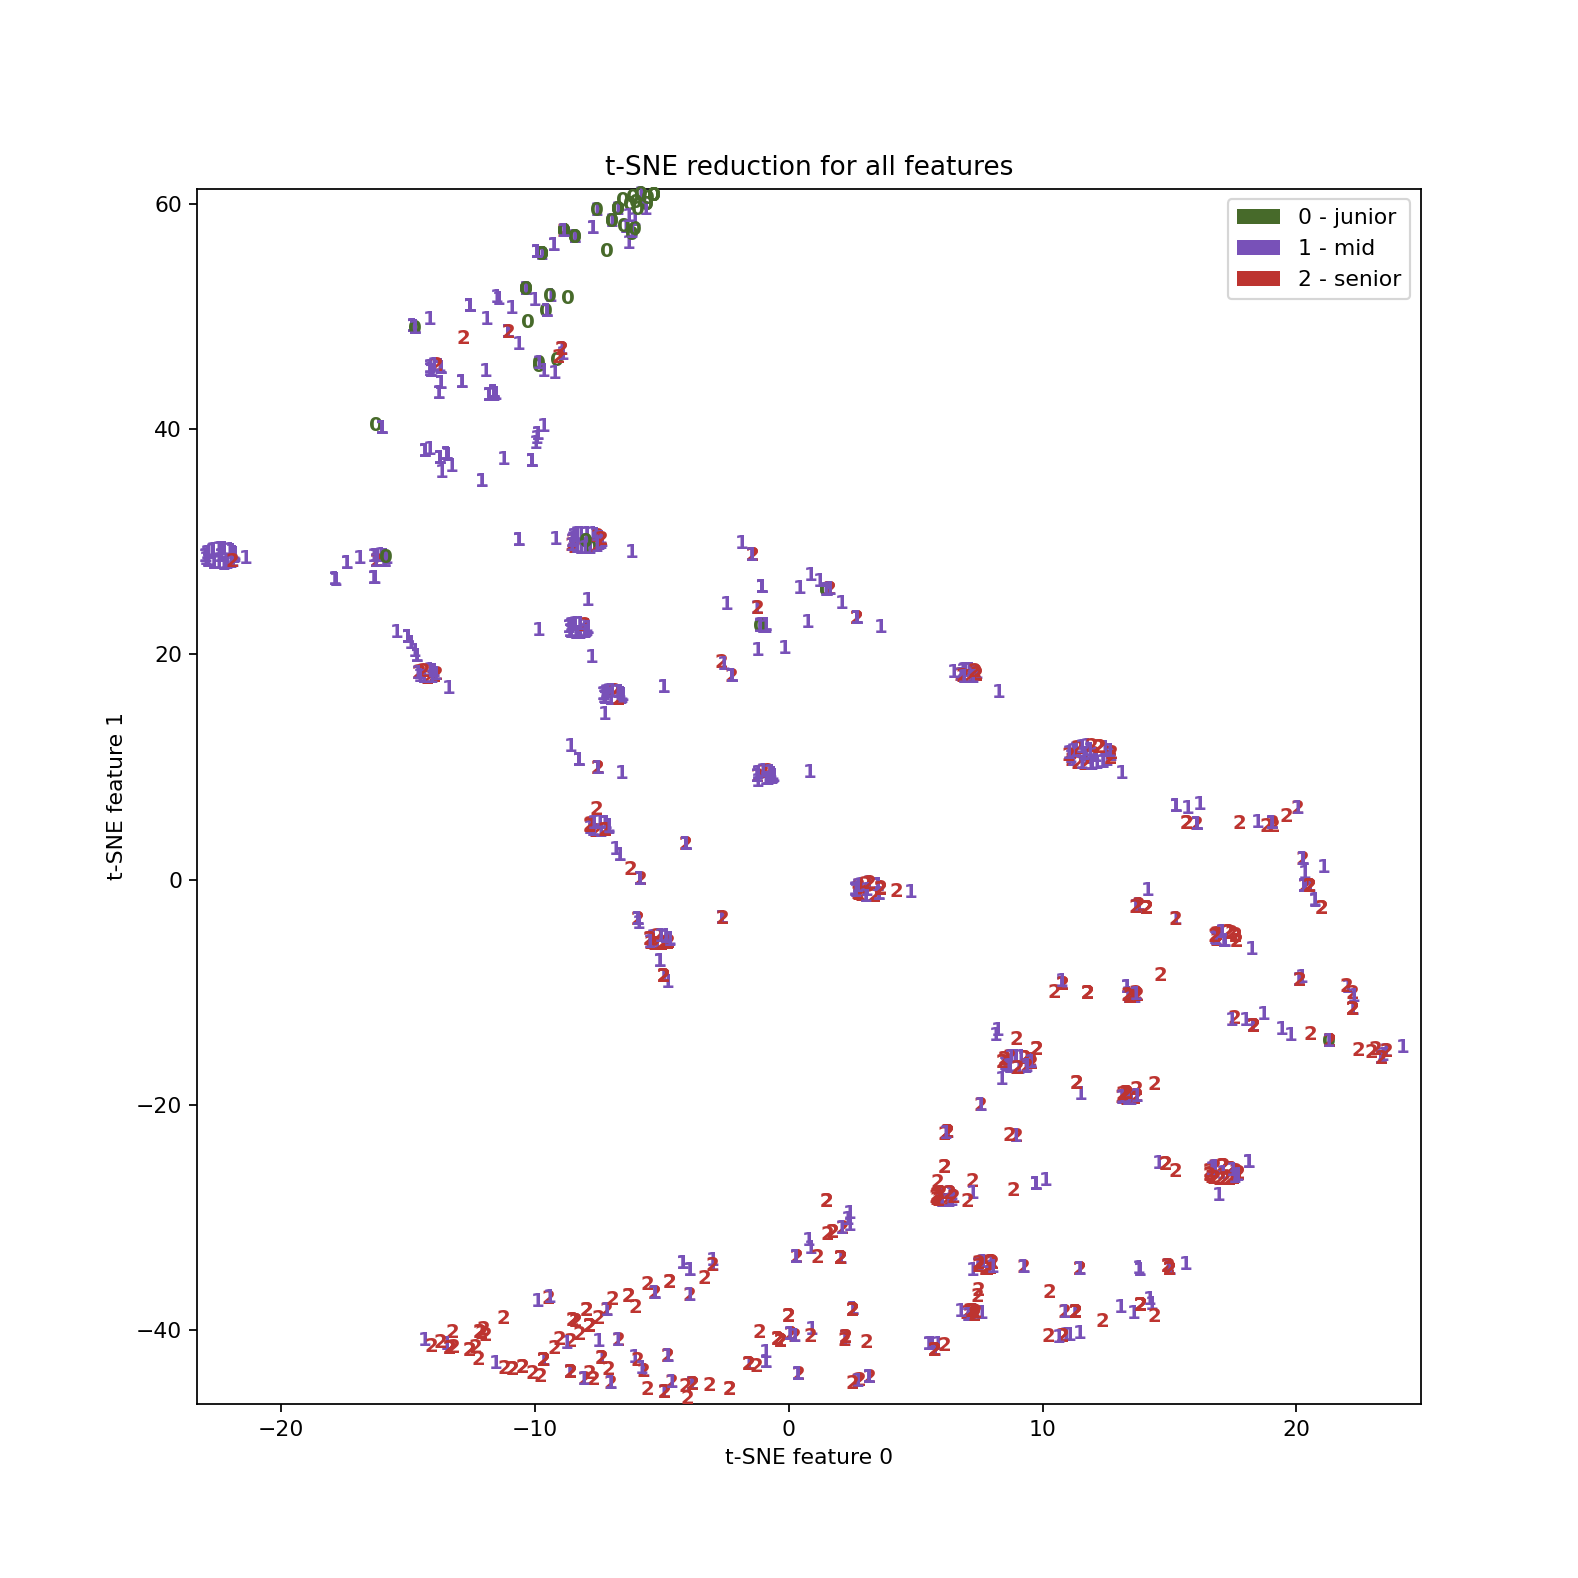

<IPython.core.display.Javascript object>


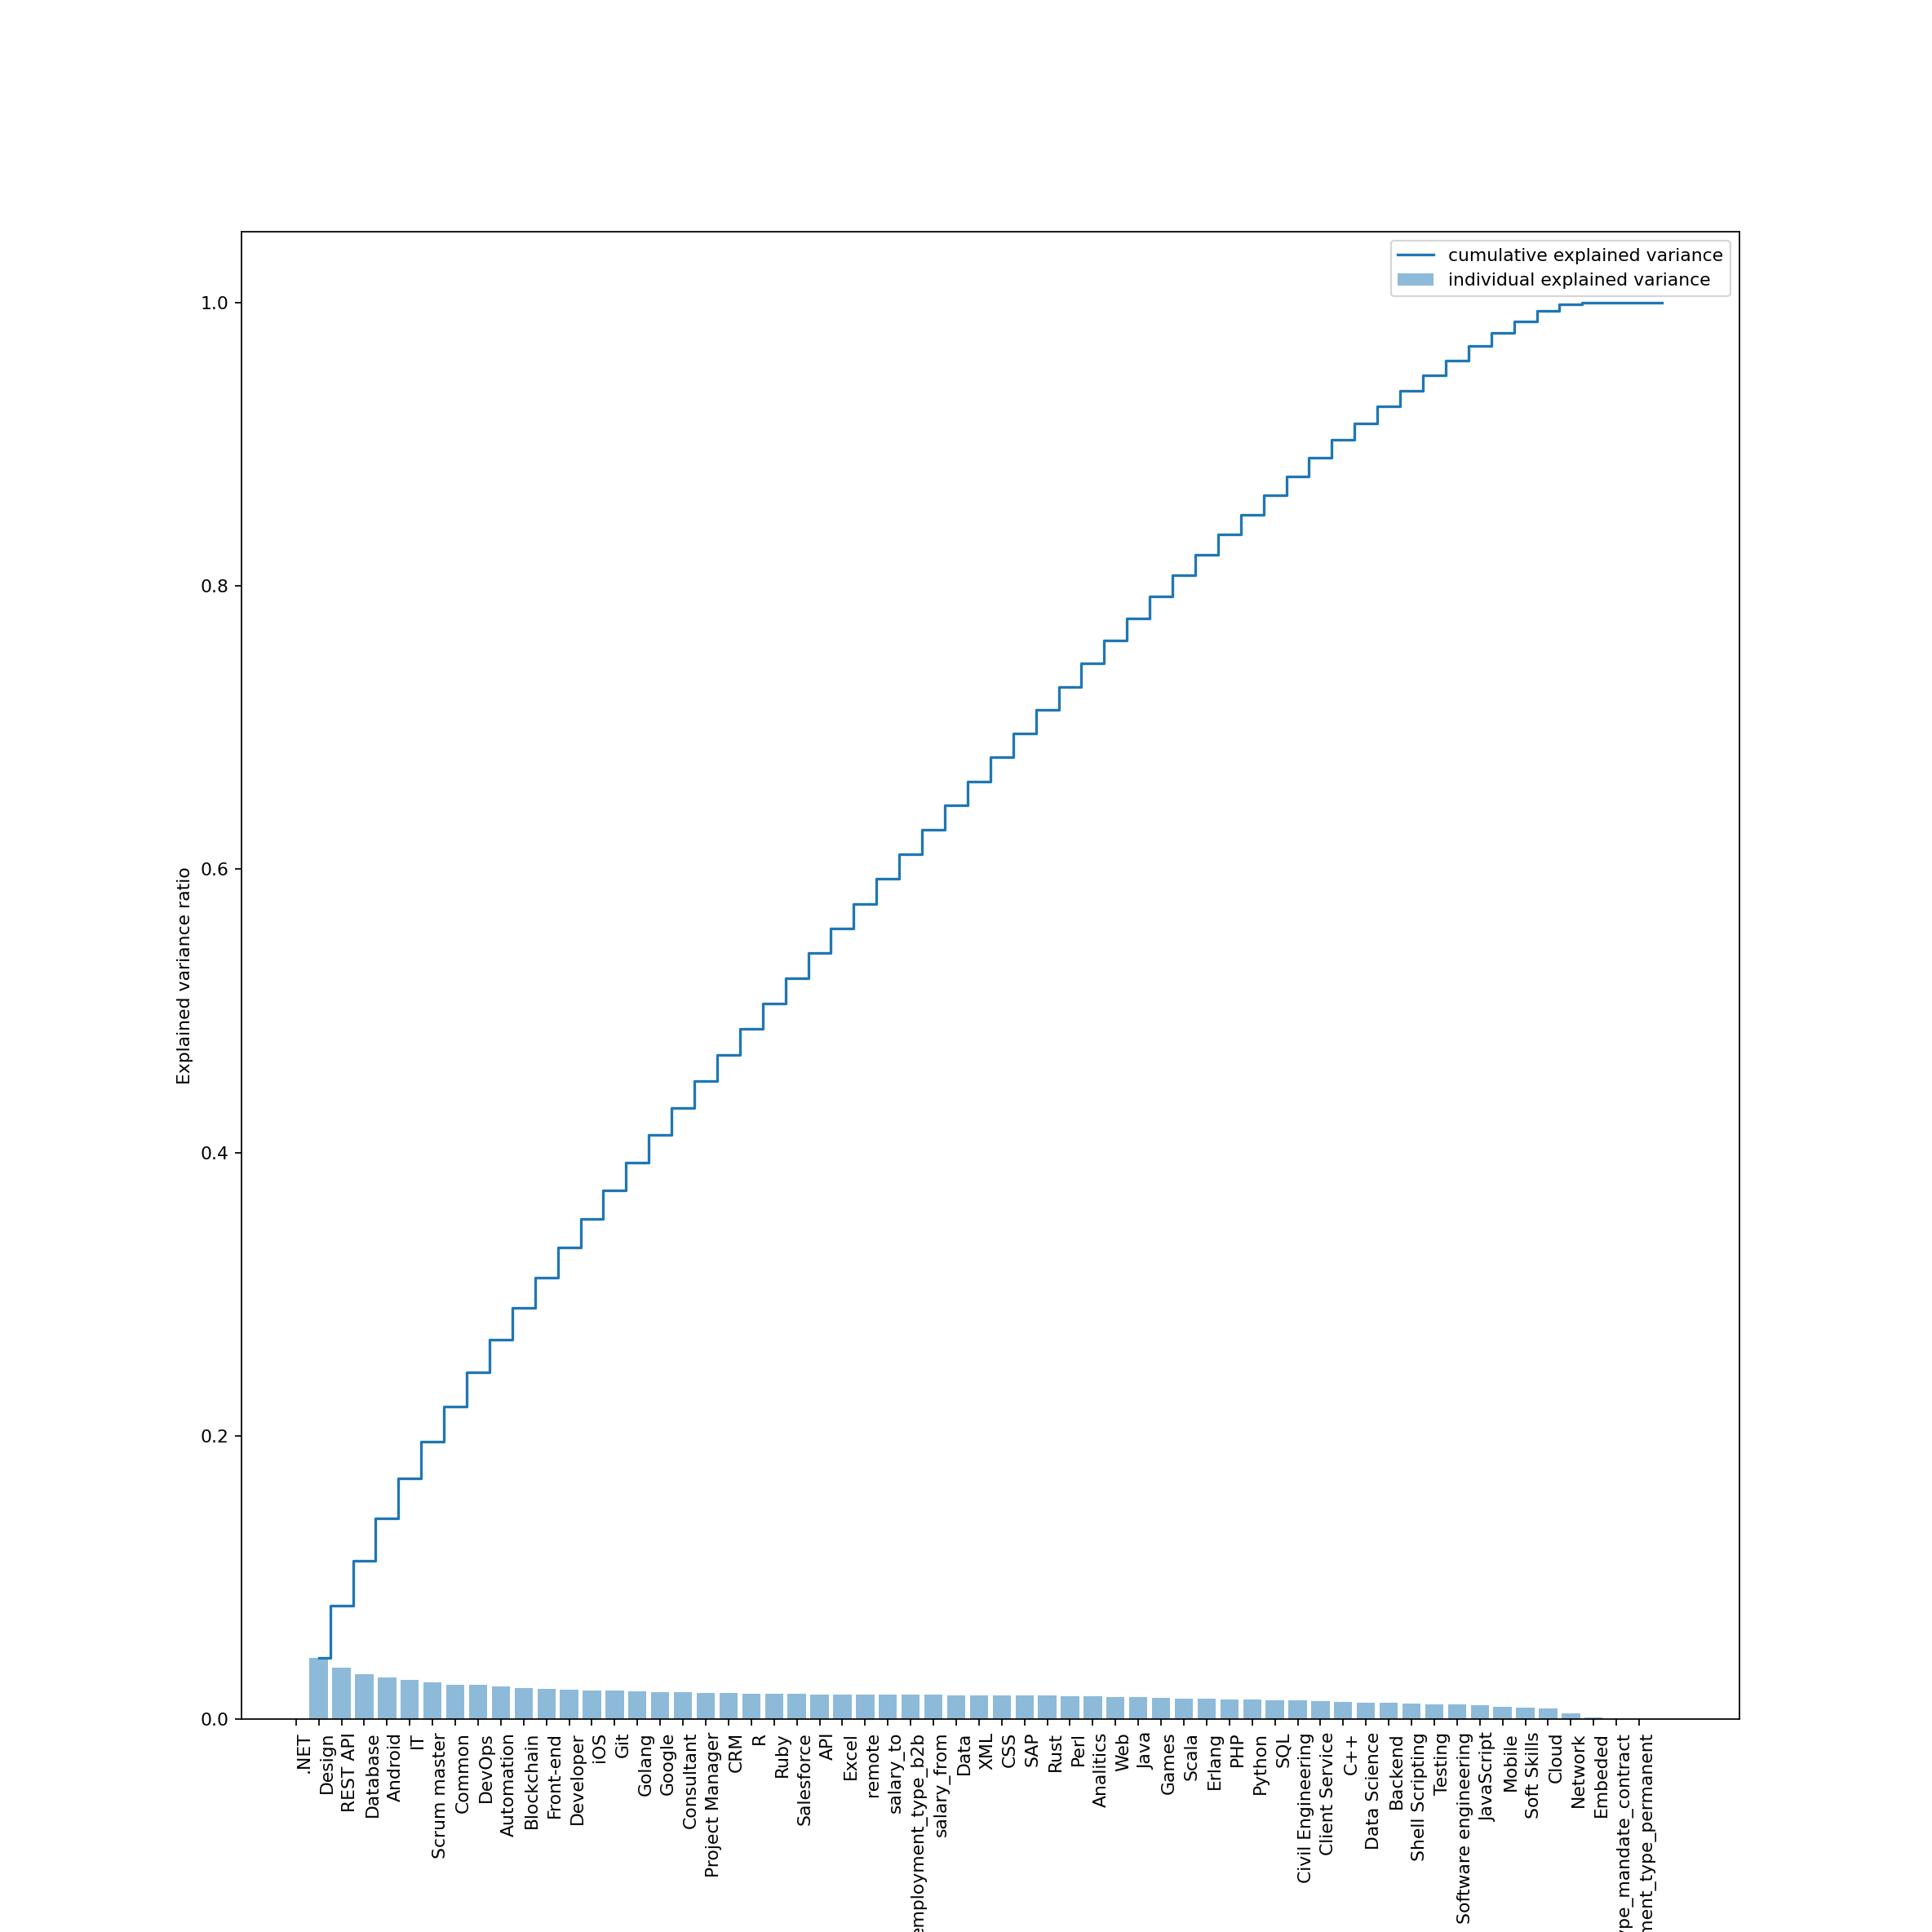

(60, 2)


<IPython.core.display.Javascript object>


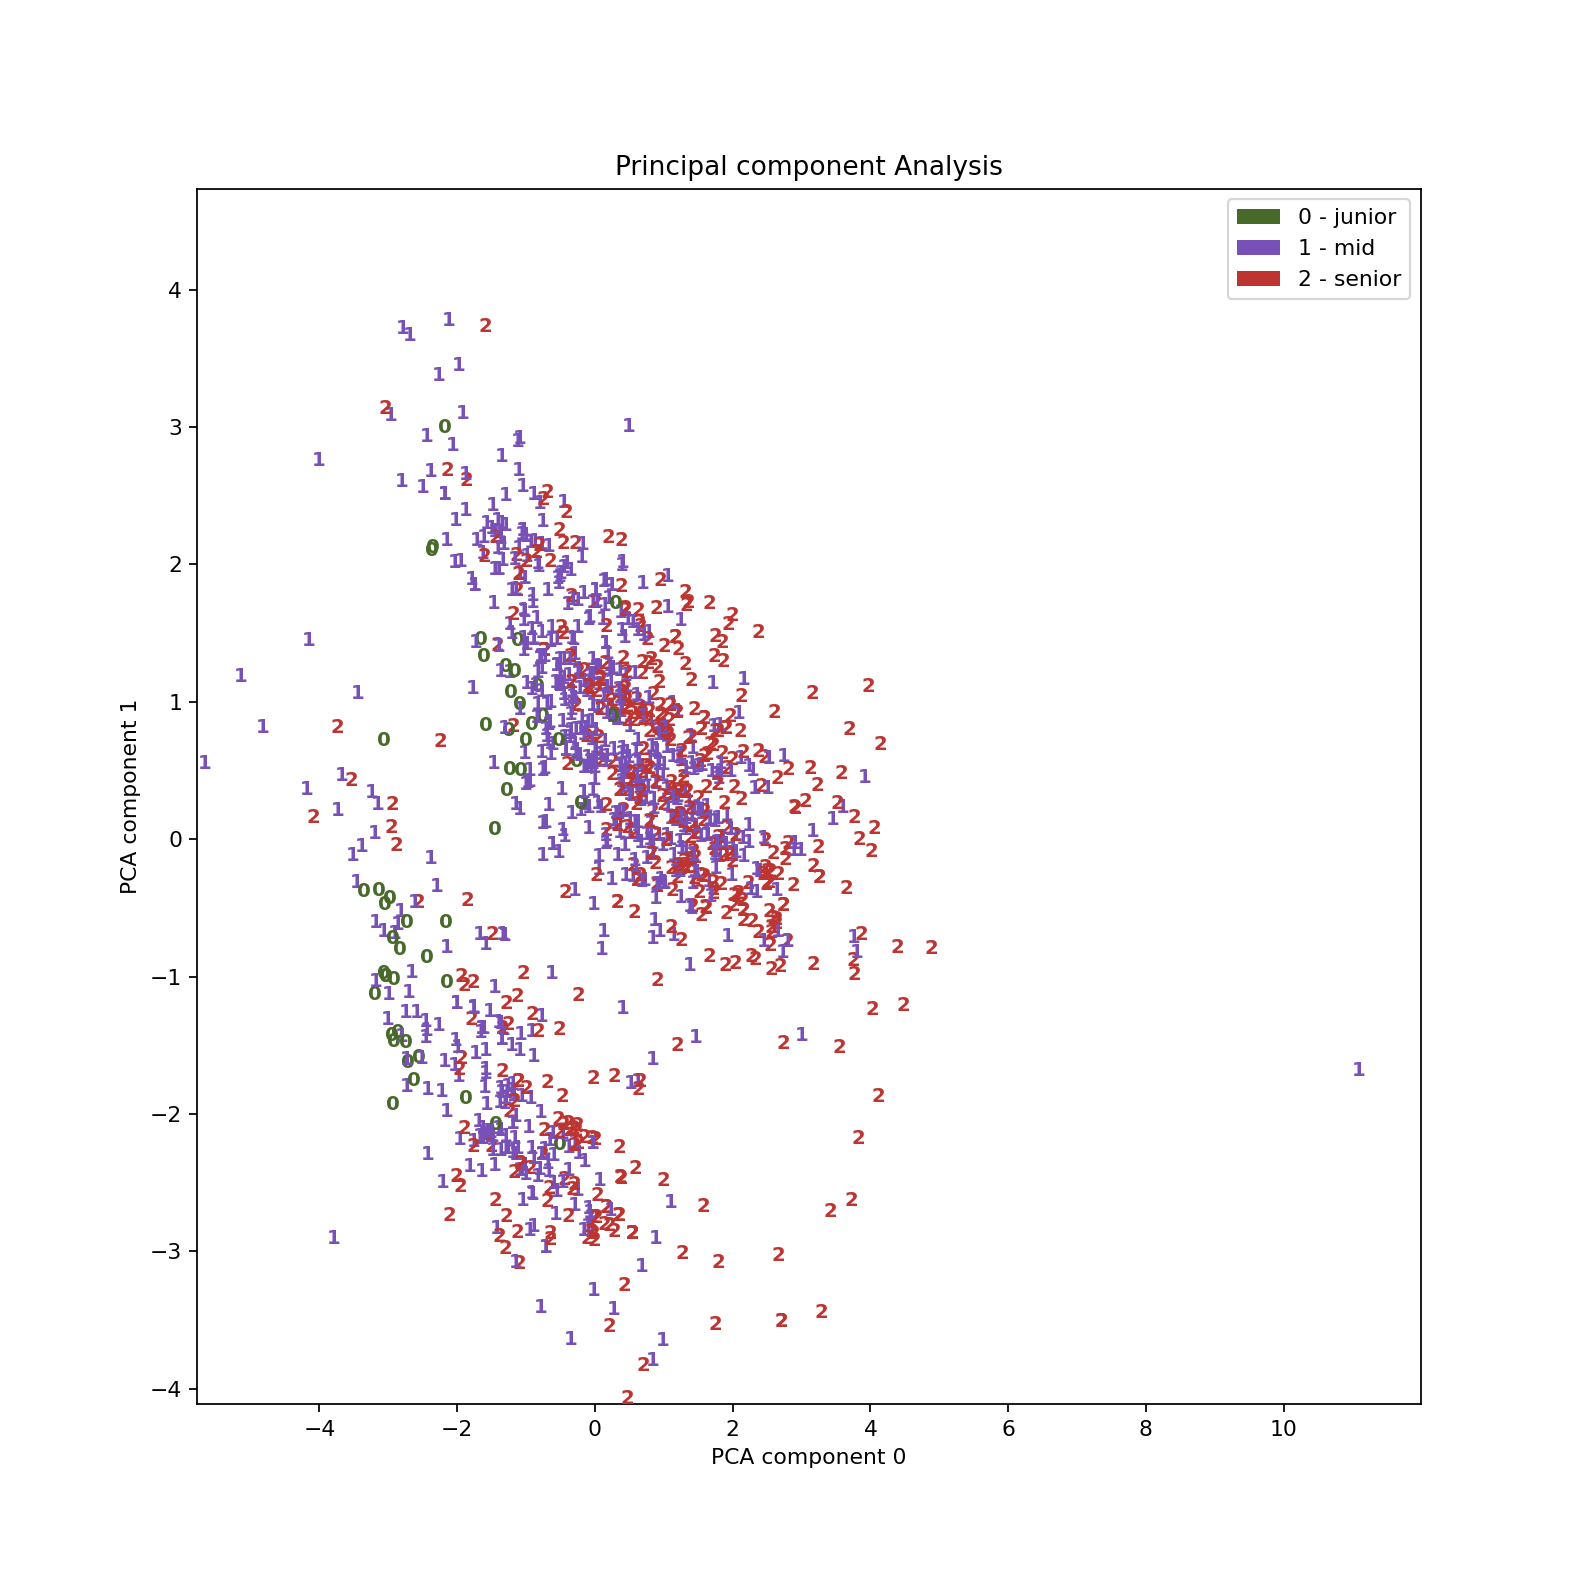

In [9]:
def move_col_to_end(df, col):
    cols_at_end = [col]
    return df[[c for c in df if c not in cols_at_end] 
            + [c for c in cols_at_end if c in df]]

pca_df = move_col_to_end(pca_df, "experience_level")
array = pca_df.values
x = array[:,0:len(pca_df.columns)-1]
y = array[:,len(pca_df.columns)-1]
x = normalize(x)
le = LabelEncoder()
y = le.fit_transform(y)
x_skills = pca_df[col_level]
x_other = pca_df[col_other]
x_all = pca_df[(col_level + col_other)]
plot_t_SNE(x_all, 35, 170)
plot_PCA_2_components(x_all)

----------------------------------------